# Koç University, Deep Learning Course (COMP541) <br/> Assignment 4: Graph Neural Networks and Transformers
### Due on January 2, 2025 (23:59:59)

In this assignment, you will implement the vanilla version of Graph Convolution
Networks (GCN) [Kipf and Welling \(2016\)](https://arxiv.org/abs/1609.02907) and Graph Attention Networks (GAT) [Veličković, et al.
\(2018\)](https://openreview.net/forum?id=rJXMpikCZ).

## Background
### Basics of GCN
Recall from the lectures, the goal of a GCN is to learn a function of signals features on a graph $G = (V, E)$, which takes as inputs:
1. he input features of each node, $x_i ∈ R^F$ (in matrix form: $X ∈ R^{|V |×F}$ )
2. some information about the graph structure, typically the adjacency matrix $A$

Each convolutional layer can be written as $H^{(l+1)} = f(H^{(l)}, A)$ for some function $f$. The function $f$ we are using for this assignment is in the form of $f(H^{(l)}, A) = σ(\hat{D}^{-1/2}\hat{A}\hat{D}^{-1/2}H^{(l)}W^{(l)})$, where $\hat{A} = A + I$ and $\hat{D}$ is the diagonal node degree matrix ($D^{-1}\hat{A}$ normalizes $\hat{A}$ such that all rows sum to one). Let $\tilde{A} = \hat{D}^{-1/2}\hat{A}\hat{D}^{-1/2}$. The GCN we will implement takes two convolution layers, $Z = f(X, A) = softmax(\tilde{A}~.~Dropout(ReLU(\tilde{A}XW^{(0)}))~.W^{(1)})$

### Basics of GAT
Graph Attention Network (GAT) is a novel convolution-style neural network. It operates on graph-structured data and leverages masked self-attentional layers. In this assignment, we will implement the graph attention layer.

### Dataset
The dataset we used for this assignment is Cora ([Sen et al. \(2008\)](http://www.cs.iit.edu/~ml/pdfs/sen-aimag08.pdf)). Cora is one of standard citation network benchmark dataset (just like MNIST dataset for computer vision tasks). It that consists of 2708 scientific publications and 5429 links. Each publication is classified into one of 7 classes. Each publication is described by a word vector (length 1433) that indicates the absence/presence of the corresponding word. This is used as the features of each node for our experiment. The task is to perform node classification (predict which class each node belongs to).

## Experiments
Experiments:
Open GCN notebook on Colab and implement the following parts.
1. Implementation of Graph Convolution Layer: Complete the code for `GraphConvolution` Class
2. Implementation of Graph Convolution Network: Complete the code for `GCN` Class
3. Train your Graph Convolution Network: After implementing the required classes, now you can train your GCN. We want you to play with the architecture (such as the number of Graph Convolution Layers, usage of Dropout etc.) and the hyperparameters, and report your results in various settings.
4. Implementation of Graph Attention Layer: Complete the code for `GraphAttentionLayer` Class
5. Train your Graph Convolution Network: After implementing the required classes, now you can train your GAT. Again, you are need to play with the structure and the hyperparameters and conduct various experiments.
6. Compare your models: Compare the evaluation results for Vanilla GCN and GAT. Comment on the discrepancy in their performance (if any) and briefly explain why you think it’s the case.

# Download the Cora data

In [ ]:
! wget https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz
! tar -zxvf cora.tgz

# import modules and set random seed

In [ ]:
import numpy as np
import scipy.sparse as sp
import torch
import pandas as pd
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import matplotlib.pyplot as plt

seed = 0

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Loading and preprocessing the data

In [ ]:
def encode_onehot(labels):
    # The classes must be sorted before encoding to enable static class encoding.
    # In other words, make sure the first class always maps to index 0.
    classes = sorted(list(set(labels)))
    classes_dict = {c: np.identity(len(classes))[i, :] for i, c in
                    enumerate(classes)}
    labels_onehot = np.array(list(map(classes_dict.get, labels)),
                             dtype=np.int32)
    return labels_onehot


def load_data(path="/content/cora/", dataset="cora", training_samples=140):
    """Load citation network dataset (cora only for now)"""
    print('Loading {} dataset...'.format(dataset))

    idx_features_labels = np.genfromtxt("{}{}.content".format(path, dataset),
                                        dtype=np.dtype(str))
    features = sp.csr_matrix(idx_features_labels[:, 1:-1], dtype=np.float32)
    labels = encode_onehot(idx_features_labels[:, -1])

    # build graph
    idx = np.array(idx_features_labels[:, 0], dtype=np.int32)
    idx_map = {j: i for i, j in enumerate(idx)}
    edges_unordered = np.genfromtxt("{}{}.cites".format(path, dataset),
                                    dtype=np.int32)
    edges = np.array(list(map(idx_map.get, edges_unordered.flatten())),
                     dtype=np.int32).reshape(edges_unordered.shape)
    adj = sp.coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])),
                        shape=(labels.shape[0], labels.shape[0]),
                        dtype=np.float32)

    # build symmetric adjacency matrix
    adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)

    features = normalize(features)
    adj = adj + sp.eye(adj.shape[0])
    adj = normalize_adj(adj)

    # Random indexes
    idx_rand = torch.randperm(len(labels))
    # Nodes for training
    idx_train = idx_rand[:training_samples]
    # Nodes for validation
    idx_val= idx_rand[training_samples:]

    adj = torch.FloatTensor(np.array(adj.todense()))
    features = torch.FloatTensor(np.array(features.todense()))
    labels = torch.LongTensor(np.where(labels)[1])

    idx_train = torch.LongTensor(idx_train)
    idx_val = torch.LongTensor(idx_val)

    return adj, features, labels, idx_train, idx_val

def normalize_adj(mx):
    """symmetric normalization"""
    rowsum = np.array(mx.sum(1))
    r_inv_sqrt = np.power(rowsum, -0.5).flatten()
    r_inv_sqrt[np.isinf(r_inv_sqrt)] = 0.
    r_mat_inv_sqrt = sp.diags(r_inv_sqrt)
    return mx.dot(r_mat_inv_sqrt).transpose().dot(r_mat_inv_sqrt)

def normalize(mx):
    """Row-normalize sparse matrix"""
    rowsum = np.array(mx.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    mx = r_mat_inv.dot(mx)
    return mx


def accuracy(output, labels):
    preds = output.max(1)[1].type_as(labels)
    correct = preds.eq(labels).double()
    correct = correct.sum()
    return correct / len(labels)

## Check the data

In [ ]:
adj, features, labels, idx_train, idx_val = load_data()

In [ ]:
print(adj)
print(adj.shape)

In [ ]:
print(features)
print(features.shape)

In [ ]:
print(labels)
print(labels.unique())
print(len(labels))

In [ ]:
print(len(idx_train))
print(len(idx_val))

# Part 1: Graph Attention Networks

## Part 1.1: Graph attention layer
A GAT is made up of multiple such layers. In this section, you will implement a single graph attention layer. Similar to the `GraphConvolution()`, this `GraphAttentionLayer()` module takes $\mathbf{h} = \{ \overrightarrow{h_1}, \overrightarrow{h_2}, \dots, \overrightarrow{h_N} \}$ where $\overrightarrow{h_i} \in \mathbb{R}^F$ as input and outputs $\mathbf{h'} = \{ \overrightarrow{h'_1}, \overrightarrow{h'_2}, \dots, \overrightarrow{h'_N} \}$, where $\overrightarrow{h'_i} \in \mathbb{R}^{F'}$. However, instead of weighing each neighbouring node based on the adjacency matrix, we will use self attention to learn the relative importance of each neighbouring node. Recall from HW4 where you are asked to write out the equation for single headed attention, here we will implement multi-headed attention, which involves the following steps:


### The initial transformation
In GCN above, you have completed similar transformation. But here, we need to define a weight matrix and perform this transformation for each head: $\overrightarrow{s^k_i} = \mathbf{W}^k \overrightarrow{h_i}$. We will perform a single linear transformation and then split it up for each head later. Note the input $\overrightarrow{h}$ has shape `[n_nodes, in_features]` and $\overrightarrow{s}$ has shape of `[n_nodes, n_heads * n_hidden]`. Remember to reshape $\overrightarrow{s}$ has shape of `[n_nodes, n_heads, n_hidden]` for later uses. Note: set `bias=False` for this linear transformation.

### attention score
We calculate these for each head $k$. Here for simplicity of the notation, we omit $k$ in the following equations. The attention scores are defined as the follows:
$e_{ij} = a(\mathbf{W} \overrightarrow{h_i}, \mathbf{W} \overrightarrow{h_j}) =a(\overrightarrow{s_i}, \overrightarrow{s_j})$,
where $e_{ij}$ is the attention score (importance) of node $j$ to node $i$.
We will have to calculate this for each head. $a$ is the attention mechanism, that calculates the attention score. The paper concatenates $\overrightarrow{s_i}$, $\overrightarrow{s_j}$ and does a linear transformation with a weight vector $\mathbf{a} \in \mathbb{R}^{2 F'}$ followed by a $\text{LeakyReLU}$. $$e_{ij} = \text{LeakyReLU} \Big(
\mathbf{a}^\top \Big[ \overrightarrow{s_i} \Vert \overrightarrow{s_j}  \Big] \Big)$$

#### How to vectorize this? Some hints:
1. `tensor.repeat()` gives you $\{\overrightarrow{s_1}, \overrightarrow{s_2}, \dots, \overrightarrow{s_N}, \overrightarrow{s_1}, \overrightarrow{s_2}, \dots, \overrightarrow{s_N}, ...\}$.

2. `tensor.repeat_interleave()` gives you
$\{\overrightarrow{s_1}, \overrightarrow{s_1}, \dots, \overrightarrow{s_1}, \overrightarrow{s_2}, \overrightarrow{s_2}, \dots, \overrightarrow{s_2}, ...\}$.

3. concatenate to get $\Big[\overrightarrow{s_i} \Vert \overrightarrow{s_j} \Big]$ for all pairs of $i, j$. Reshape $\overrightarrow{s_i} \Vert \overrightarrow{s_j}$ has shape of `[n_nodes, n_nodes, n_heads, 2 * n_hidden]`

4. apply the attention layer and non-linear activation function to get $e_{ij} = \text{LeakyReLU} \Big( \mathbf{a}^\top \Big[ \overrightarrow{s_i} \Vert \overrightarrow{s_j}  \Big] \Big)$, where $\mathbf{a}^\top$ is a single linear transformation that maps from dimension `n_hidden * 2` to `1`. Note: set the `bias=False` for this linear transformation. $\mathbf{e}$ is of shape `[n_nodes, n_nodes, n_heads, 1]`. Remove the last dimension `1` using `squeeze()`.


#### Perform softmax
First, we need to mask $e_{ij}$ based on adjacency matrix. We only need to sum over the neighbouring nodes for the attention calculation. Set the elements in $e_{ij}$ to $- \infty$ if there is no edge from $i$ to $j$ for the softmax calculation. We need to do this for all heads and the adjacency matrix is the same for each head. Use `tensor.masked_fill()` to mask $e_{ij}$ based on adjacency matrix for all heads. Hint: reshape the adjacency matrix to `[n_nodes, n_nodes, 1]` using `unsqueeze()`.
Now we are ready to normalize attention scores (or coefficients) $$\alpha_{ij} = \text{softmax}_j(e_{ij}) =  \frac{\exp(e_{ij})}{\sum_{k \in \mathcal{N}_i} \exp(e_{ik})}$$

#### Apply dropout
Apply the dropout layer. (this step is easy)

#### Calculate final output for each head
$$\overrightarrow{h'^k_i} = \sum_{j \in \mathcal{N}_i} \alpha^k_{ij} \overrightarrow{s^k_j}$$


#### Concat or Mean
Finally we concateneate the transformed features: $\overrightarrow{h'_i} = \Bigg\Vert_{k=1}^{K} \overrightarrow{h'^k_i}$. In the code, we only need to reshape the tensor to shape of `[n_nodes, n_heads * n_hidden]`. Note that if it is the final layer, then it doesn't make sense to do concatenation anymore. Instead, we sum over the `n_heads` dimension: $\overrightarrow{h'_i} = \frac{1}{K} \sum_{k=1}^{K} \overrightarrow{h'^k_i}$.

In [ ]:
class GraphAttentionLayer(nn.Module):

    def __init__(self, in_features: int, out_features: int, n_heads: int,
                 is_concat: bool = True,
                 dropout: float = 0.6,
                 alpha: float = 0.2):
        """
        in_features: F, the number of input features per node
        out_features: F', the number of output features per node
        n_heads: K, the number of attention heads
        is_concat: whether the multi-head results should be concatenated or averaged
        dropout: the dropout probability
        alpha: the negative slope for leaky relu activation
        """
        super(GraphAttentionLayer, self).__init__()

        self.is_concat = is_concat
        self.n_heads = n_heads

        if is_concat:
            assert out_features % n_heads == 0
            self.n_hidden = out_features // n_heads
        else:
            self.n_hidden = out_features

        # TODO: initialize the following modules:
        # (1) self.W: Linear layer that transform the input feature before self attention.
        # You should NOT use for loops for the multiheaded implementation (set bias = Flase)
        # (2) self.attention: Linear layer that compute the attention score (set bias = Flase)
        # (3) self.activation: Activation function (LeakyReLU whith negative_slope=alpha)
        # (4) self.softmax: Softmax function (what's the dim to compute the summation?)
        # (5) self.dropout_layer: Dropout function(with ratio=dropout)
        ################ your code here ########################





        ########################################################

    def forward(self, h: torch.Tensor, adj_mat: torch.Tensor):
        # Number of nodes
        n_nodes = h.shape[0]

        # TODO:
        # (1) calculate s = Wh and reshape it to [n_nodes, n_heads, n_hidden]
        #     (you can use tensor.view() function)
        # (2) get [s_i || s_j] using tensor.repeat(), repeat_interleave(), torch.cat(), tensor.view()
        # (3) apply the attention layer
        # (4) apply the activation layer (you will get the attention score e)
        # (5) remove the last dimension 1 use tensor.squeeze()
        # (6) mask the attention score with the adjacency matrix (if there's no edge, assign it to -inf)
        #     note: check the dimensions of e and your adjacency matrix. You may need to use the function unsqueeze()
        # (7) apply softmax
        # (8) apply dropout_layer
        ############## Your code here #########################################






        #######################################################################

        # Summation
        h_prime = torch.einsum('ijh,jhf->ihf', a, s) #[n_nodes, n_heads, n_hidden]


        # TODO: Concat or Mean
        # Concatenate the heads
        if self.is_concat:
            ############## Your code here #########################################


            #######################################################################
        # Take the mean of the heads (for the last layer)
        else:
            ############## Your code here #########################################



            #######################################################################






## Part 1.2: Define GAT network
it's really similar to how we defined GCN. You can follow the paper to set the number of attention layers and the activation function

In [ ]:
class GAT(nn.Module):

    def __init__(self, nfeat: int, n_hidden: int, n_classes: int, n_heads: int, dropout: float, alpha: float):
        """
        in_features: the number of features per node
        n_hidden: the number of features in the first graph attention layer
        n_classes: the number of classes
        n_heads: the number of heads in the graph attention layers
        dropout: the dropout probability
        alpha: the negative input slope for leaky ReLU of the attention layer
        """
        super().__init__()

        # TODO: Set your GraphAttentionLayers, activation function and possibly extensions (such as Dropout)


    def forward(self, x: torch.Tensor, adj_mat: torch.Tensor):
        """
        x: the features vectors
        adj_mat: the adjacency matrix
        """
        # TODO: implement the forward function


## Part 1.3: Training GAT

Play with the structure and the experiment settings and report your results as stated.

In [ ]:
# TODO: SET YOUR HYPERPARAMETERS HERE

In [ ]:
# TODO: SET YOUR MODE AND OPTIMIZER HERE


adj, features, labels, idx_train, idx_val = load_data(training_samples=args["training_samples"])
adj, features, labels, idx_train, idx_val = adj.to(device), features.to(device), labels.to(device), idx_train.to(device), idx_val.to(device)

In [ ]:
# Train model
t_total = time.time()
for epoch in range(args["epochs"]):
    train(epoch)
print("Optimization Finished!")
print("Total time elapsed: {:.4f}s".format(time.time() - t_total))

# Testing
test()

# Question: (Your task)
Compare the evaluation results for Vanilla GCN (from the tutorial session) and GAT. Comment on the discrepancy in their performance (if any) and briefly explain why you think it's the case.

**Your answer here:**

## Part 2: Transformers

In the tutorial session, you learned how to use a transformer model for language modeling. This is a type of decoder-only model, where we directly use the input embeddings to generate text. Here, we will focus on a different task instead: translation. To do this, we will need to use an encoder-decoder architecture.

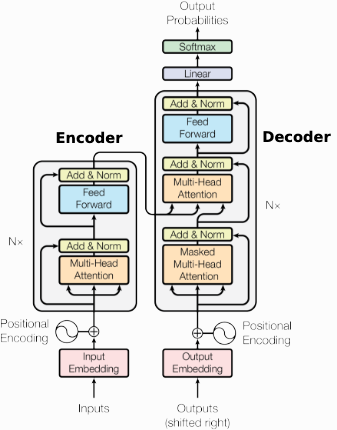



### Part 2.1: Transformer Layers

Here, you will need to implement a few different layers.
1) A multi-head attention block.
2) A feedforward network.
3) A positional encoding (in the tutorial we used a learned positional encoding. In this assignment, you should implement a sinusoidal positional encoding).

***Note that the template code provided for you below is only a template, and you may modify the parameters for the functions as needed.***

Once you have these, you will need to combine them together into an encoder and a decoder. Each of these should have $N$ sets of multi-head attention + feedforward. However, the encoder and decoder have to be implemented slightly differently, as the decoder requires masking.

Additionally, since this is a translation task, we will need two sets of word embeddings (the input embeddings corresponding to the starting language, and the output embeddings corresponding to the translated language).

#### Multi-Head Attention
Multi-head attention should be implemented slightly differently here, compared to the tutorial. Specifically, your multi-head attention implementation should allow for masking. This means that if an input mask is provided, everything that is masked out (a value of $0$ in the mask) should not contribute to the attention calculations.

It is crucial that the decoder is properly masked. This is because we do not want to allow the decoder to apply attention to output positions it has not seen yet.

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, input_dimension, hidden_dim, num_heads):
        super().__init__()
        # TODO

    def forward(self, x, mask=None):
        # TODO

class FeedForward(nn.Module):
    def __init__(self, input_dimension, hidden_dim, output_dim, n_layers, dropout=0.0):
        super().__init__()
        # TODO

    def forward(self, x):
        # TODO

class PositionalEncoding(nn.Module):
    def __init__(self, hidden_dim, max_len=5000):
        super().__init__()
        # TODO
    
    def forward(self, x):
        # TODO

In [ ]:
class TransformerEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_heads, num_layers, output_dim, dropout=0.1):
        super().__init__()
        # TODO

    def forward(self, x, mask=None):
        # TODO


class TransformerDecoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_heads, num_layers, output_dim, dropout=0.1):
        super().__init__()
        # TODO

In [ ]:
class Transformer(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_heads, num_layers, output_dim, dropout=0.1):
        super().__init__()
        # TODO

    def forward(self, x, mask=None):
        # TODO

### Part 2.2: Training the Transformer

We will be training our transformer on English -> Turkish translation. In the provided dataset, there are files labeled `{language}.{split}`, for example `en.train`. These are paired data, meaning that each line in the english file has the corresponding translation in the turkish file. There are also 0.5, 0.25, and 0.125 files, which correspond to smaller versions of the training data. Based on training times you encounter, you can use the smaller versions if needed.

As with the language modeling task, the model will output logits for each word, which you will then use for the loss.

#### Setting up the Data

Here, we will use word tokens, similar to the RNN assignment. However, you will need to have two sets of tokens, one for the starting language and one for the ending language. You are free to copy the data loading code from assignment 3 and make the necessary modifications, or you may implement the data loading in your own way. However, since we are no longer using fixed length sentences, you will need to implement padding (recall assignment 1).

#### Training the Model

To train the model, you can use a similar approach to the tutorial. However, to calculate the loss, you will need both the source and target language tokens.

You should test with multiple sets of hyperparameters and provide the values and results of the best set on the validation data. For this, you should implement a function to calculate the accuracy.

### Part 2.3: Attention Visualization

We will now set up some attention visualization, in order to understand what the model has learned. Given an input of length `N`, an attention map is an `N x N` matrix, where the $(i, j)$ value represents the strength of the attention between the i-th input and the j-th input. 

In order to get the attention maps, you should take the output of each head of the multi-head attention at each layer of the model. The provided function below will help visualize the attention maps given some input data. Run this and include some results on different heads/different layers of the model. Given an explanation of what the results mean.

In [ ]:
# Here, input_data should be the list of input tokens (in text form, not integers), attn_maps are the attention maps, and idx is the batch index
def plot_attention_maps(input_data, attn_maps, idx=0):
    if input_data is not None:
        input_data = input_data[idx].detach().cpu().numpy()
    else:
        input_data = np.arange(attn_maps[0][idx].shape[-1])
    attn_maps = [m[idx].detach().cpu().numpy() for m in attn_maps]

    num_heads = attn_maps[0].shape[0]
    num_layers = len(attn_maps)
    seq_len = input_data.shape[0]
    fig_size = 4 if num_heads == 1 else 3
    fig, ax = plt.subplots(num_layers, num_heads, figsize=(num_heads*fig_size, num_layers*fig_size))
    if num_layers == 1:
        ax = [ax]
    if num_heads == 1:
        ax = [[a] for a in ax]
    for row in range(num_layers):
        for column in range(num_heads):
            ax[row][column].imshow(attn_maps[row][column], origin='lower', vmin=0)
            ax[row][column].set_xticks(list(range(seq_len)))
            ax[row][column].set_xticklabels(input_data.tolist())
            ax[row][column].set_yticks(list(range(seq_len)))
            ax[row][column].set_yticklabels(input_data.tolist())
            ax[row][column].set_title(f"Layer {row+1}, Head {column+1}")
    fig.subplots_adjust(hspace=0.5)
    plt.show()

# What to submit

As in previous assignments, you have several options on how you can make the submission. The important part is, we need to see your code and your results in order to be able to grade you properly.

- You can write the answers and experiment results to your notebook and turn it into a pdf and submit it.
- You can put your experiment results and explanations to a seperate file as a report, and submit this report and the notebook pdf together.
- As long as we can see your code and also the experiment results and answers, you will be fine.

# Late Policy
You may use up to 7 grace days over the course of the semester for the |assignments you will take. You can only use up to 3 grace days per assignment.


# Academic Integrity
All work on assignments must be done individually unless stated otherwise. Turning in someone else’s work, in whole or in part, as your own will be considered as a violation of academic integrity. Please note that the former condition also holds for the material found on the web as everything on the web has been written by someone else.

## Acknowledgements
Adapted from University of Toronto, Neural Networks and Deep Learning course (CSC413/2516).